In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glasspy.predict import GlassNet
from glasspy.data import SciGlass
from functools import partial
 
from funcoes import cria_populacao_compostos as cria_populacao
from funcoes import funcao_objetivo_pop as funcao_objetivo_pop
from funcoes import selecao_torneio_min as funcao_selecao
from funcoes import cruzamento_ponto_duplo as funcao_cruzamento
from funcoes import mutacao_sucessiva as funcao_mutacao_1
from funcoes import mutacao_simples as funcao_mutacao_2
from funcoes import preco_composicao

C:\Users\jose23038\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [2]:
df_compounds_and_prices = pd.read_csv('../analise_exploratoria/Prices.csv',sep=',')

COMPOUNDS = list(df_compounds_and_prices['Oxide Coumpounds'])
PRECOS = list(df_compounds_and_prices['Price per gram(dolar/gram)'])
NUM_COMPOUNDS = len(COMPOUNDS)
VALOR_MAX_COMPOUNDS = 100

TAMANHO_POPULACAO = 30
NUM_GERACOES = 2
CHANCE_DE_CRUZAMENTO = 0.5
CHANCE_DE_MUTACAO = 0.05
CHANCE_DE_MUTACAO_POR_GENE = 0.25
TAMANHO_TORNEIO = 3

In [3]:
source = SciGlass()
MODEL = GlassNet()

funcao_objetivo = partial(funcao_objetivo_pop, lista_de_compostos=COMPOUNDS, lista_de_precos=PRECOS, modelo=MODEL)

C:\Users\jose23038\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:

populacao = cria_populacao(TAMANHO_POPULACAO, NUM_COMPOUNDS, VALOR_MAX_COMPOUNDS)

hall_da_fama = []

geracoes = np.arange(1,NUM_GERACOES+1,1)
melhores_das_geracoes = []
melhores_hardness = []
melhores_modulos_young = []
melhores_precos = []
composicoes_melhores = []
numeros_de_compostos_usados = []

for n in range(NUM_GERACOES):
    #print(f'Geração {n}', end='\r') 
    
    # Seleção
    fitness = funcao_objetivo(populacao)        
    selecionados = funcao_selecao(populacao, fitness, TAMANHO_TORNEIO)
    
    # Cruzamento
    proxima_geracao = []
    for pai, mae in zip(selecionados[::2], selecionados[1::2]):
        individuo1, individuo2 = funcao_cruzamento(pai, mae, CHANCE_DE_CRUZAMENTO)
        proxima_geracao.append(individuo1)
        proxima_geracao.append(individuo2)
    
    # Mutação
    funcao_mutacao_1(proxima_geracao, CHANCE_DE_MUTACAO, CHANCE_DE_MUTACAO_POR_GENE, VALOR_MAX_COMPOUNDS)
    funcao_mutacao_2(proxima_geracao, CHANCE_DE_MUTACAO, VALOR_MAX_COMPOUNDS)
        
    # Atualização do hall da fama
    fitness = funcao_objetivo(proxima_geracao)
        
    menor_fitness = min(fitness)
    indice = fitness.index(menor_fitness)
    hall_da_fama.append(proxima_geracao[indice])    
    melhores_das_geracoes.append(menor_fitness)
    melhor_individuo_geracao = hall_da_fama[n]

    dict_composition = dict(zip(COMPOUNDS, melhor_individuo_geracao))
    predicao = MODEL.predict(dict_composition)
    preco_melhor_local = preco_composicao(melhor_individuo_geracao, PRECOS)


    
    dicionario_composicao_limpa = {chave: valor for chave, valor in dict_composition.items() if valor != 0}
    numero_de_compostsos = len(list(dicionario_composicao_limpa.keys()))
    
    
    melhores_hardness.append(predicao['Microhardness'].iloc[0])
    melhores_modulos_young.append(predicao['YoungModulus'].iloc[0])
    melhores_precos.append(preco_melhor_local)
    composicoes_melhores.append(dicionario_composicao_limpa)
    numeros_de_compostos_usados.append(numero_de_compostsos)
    # Encerramento
    populacao = proxima_geracao
        
fitness = funcao_objetivo(hall_da_fama)
maior_fitness = max(fitness)
indice = fitness.index(maior_fitness)
melhor_individuo_observado = hall_da_fama[indice]
melhor_individuo_observado

[97,
 31,
 81,
 8,
 77,
 7,
 35,
 41,
 56,
 1,
 23,
 60,
 12,
 0,
 91,
 56,
 76,
 6,
 95,
 74,
 44,
 21,
 3,
 9,
 78,
 87,
 21,
 45,
 69,
 19,
 24,
 23,
 9,
 66,
 56,
 98,
 10,
 76,
 16,
 89,
 18,
 78,
 36,
 70,
 73,
 77,
 6,
 94,
 47,
 22,
 14,
 32,
 85,
 16,
 41,
 81,
 5,
 81,
 6,
 44,
 68,
 1,
 71,
 47,
 26,
 40,
 39,
 25,
 62,
 43,
 9,
 30,
 83,
 7,
 94,
 45,
 97,
 63,
 0,
 55,
 46,
 63,
 9,
 80,
 20,
 12,
 2,
 76,
 20,
 7,
 10,
 64,
 50,
 40,
 39,
 24,
 55,
 8,
 1,
 33,
 0,
 100,
 36,
 37,
 71,
 13,
 62,
 98,
 90,
 86,
 66,
 2,
 3,
 29,
 55,
 52,
 0,
 53,
 20,
 42,
 8,
 66,
 72,
 60,
 63,
 20]

In [5]:
dict_composition = dict(zip(COMPOUNDS, melhor_individuo_observado))
display(dict_composition)
predicao = MODEL.predict(dict_composition)
predicao

{'SiO2': 97,
 'P2O5': 31,
 'ZrO2': 81,
 'Na2O': 8,
 'Al2O3': 77,
 'Fe2O3': 7,
 'CaO': 35,
 'MgO': 41,
 'MnO': 56,
 'GeO2': 1,
 'Li2O': 23,
 'Ta2O5': 60,
 'ZnO': 12,
 'SrO': 0,
 'CdO': 91,
 'SnO2': 56,
 'B2O3': 76,
 'La2O3': 6,
 'Ga2O3': 95,
 'Y2O3': 74,
 'TiO2': 44,
 'Nb2O5': 21,
 'PbO': 3,
 'HfO2': 9,
 'WO3': 78,
 'Sb2O3': 87,
 'Bi2O3': 21,
 'BaO': 45,
 'Cr2O3': 69,
 'Cu2O': 19,
 'BeO': 24,
 'CuO': 23,
 'Nd2O3': 9,
 'CeO2': 66,
 'Cs2O': 56,
 'As2O3': 98,
 'NH4NO3': 10,
 'MoO3': 76,
 'FeO': 16,
 'Mn2O3': 89,
 'SO2': 18,
 'Ag2O': 78,
 'TeO2': 36,
 'CoO': 70,
 'In2O3': 73,
 'Sc2O3': 77,
 'NiO': 6,
 'V2O5': 94,
 'Li2SO4': 47,
 'As2O5': 22,
 'MnO2': 14,
 'Sm2O3': 32,
 'Gd2O3': 85,
 'Tb2O3': 16,
 'Dy2O3': 41,
 'Ho2O3': 81,
 'Er2O3': 5,
 'Yb2O3': 81,
 'Co3O4': 6,
 'Fe3O4': 44,
 'SnO': 68,
 'Mn3O4': 1,
 'Pr2O3': 71,
 'CrO3': 47,
 'Na2SO4': 26,
 'Pr6O11': 40,
 'Co2O3': 39,
 'Ti2O3': 25,
 '(NH4)2SO4': 62,
 'K2SO4': 43,
 'Cs2SO4': 9,
 'Eu2O3': 30,
 'SeO2': 83,
 'Lu2O3': 7,
 'BiOCl': 94,
 'ZnSO4'

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,...,Cp1673K,TMaxGrowthVelocity,MaxGrowthVelocity,CrystallizationPeak,CrystallizationOnset,SurfaceTensionAboveTg,SurfaceTension1173K,SurfaceTension1473K,SurfaceTension1573K,SurfaceTension1673K
0,2979.301413,1509.791006,1188.851168,923.043238,1266.361929,1392.464093,916.700498,891.355448,945.422233,1023.492444,...,1549.560875,922.228785,-1.455071,1455.603986,1640.257382,0.61893,0.428889,0.101727,0.395164,1.75569


In [6]:
#sorted(list(dict_composition.values()))

In [7]:
count = 0
for i in dict_composition.values():
    if i != 0:
        count += 1
print(f"{count}/{len(COMPOUNDS)} compostos utilizados")

122/126 compostos utilizados


In [8]:
compostos_usados = len(list(dict_composition.values())) - (list(dict_composition.values())).count(0)

print(f"{compostos_usados}/{len(COMPOUNDS)} compostos utilizados")

122/126 compostos utilizados


In [9]:
from funcoes import preco_composicao

preco = preco_composicao(melhor_individuo_observado, PRECOS)

print(f"Preço: {preco}")
print(f"Módulo de Young: {float(predicao['YoungModulus'].iloc[0])}")
print(f"Microdureza: {float(predicao['Microhardness'].iloc[0])}")

Preço: 12.66231621079504
Módulo de Young: 121.10090611963687
Microdureza: 10.944235405481077


In [10]:
df_compounds_and_prices['Price per gram(dolar/gram)'].describe()

count    126.000000
mean      19.570842
std       65.880195
min        0.022800
25%        0.502725
50%        2.820000
75%       10.550000
max      593.000000
Name: Price per gram(dolar/gram), dtype: float64

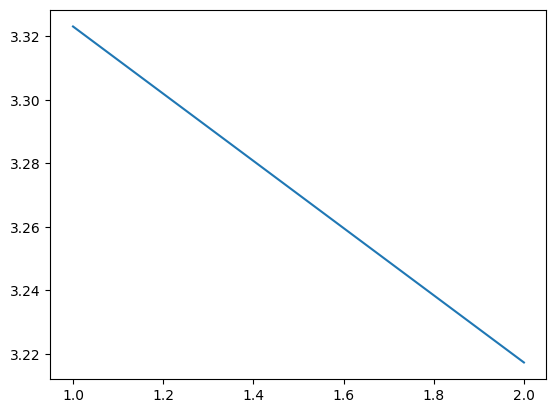

In [11]:
plt.plot(geracoes,melhores_das_geracoes)

In [12]:
dicionario= {
   'Preço':[preco],
   'Módulo de Young': [float(predicao['YoungModulus'].iloc[0])],
   'Microdureza': [float(predicao['Microhardness'].iloc[0])]

}

out = pd.DataFrame(dicionario)
out.to_excel('dados_melhor_candidato.xlsx')
evolucao = pd.DataFrame()
evolucao['Gerações'] = geracoes
evolucao['Score'] = melhores_das_geracoes
evolucao['Microhardness'] = melhores_hardness
evolucao['Módulo de Young'] = melhores_modulos_young
evolucao['Preços'] = melhores_precos
evolucao['Número de compostos usados']=numeros_de_compostos_usados
evolucao['Composição'] = composicoes_melhores
evolucao.to_excel('evolucao.xlsx')